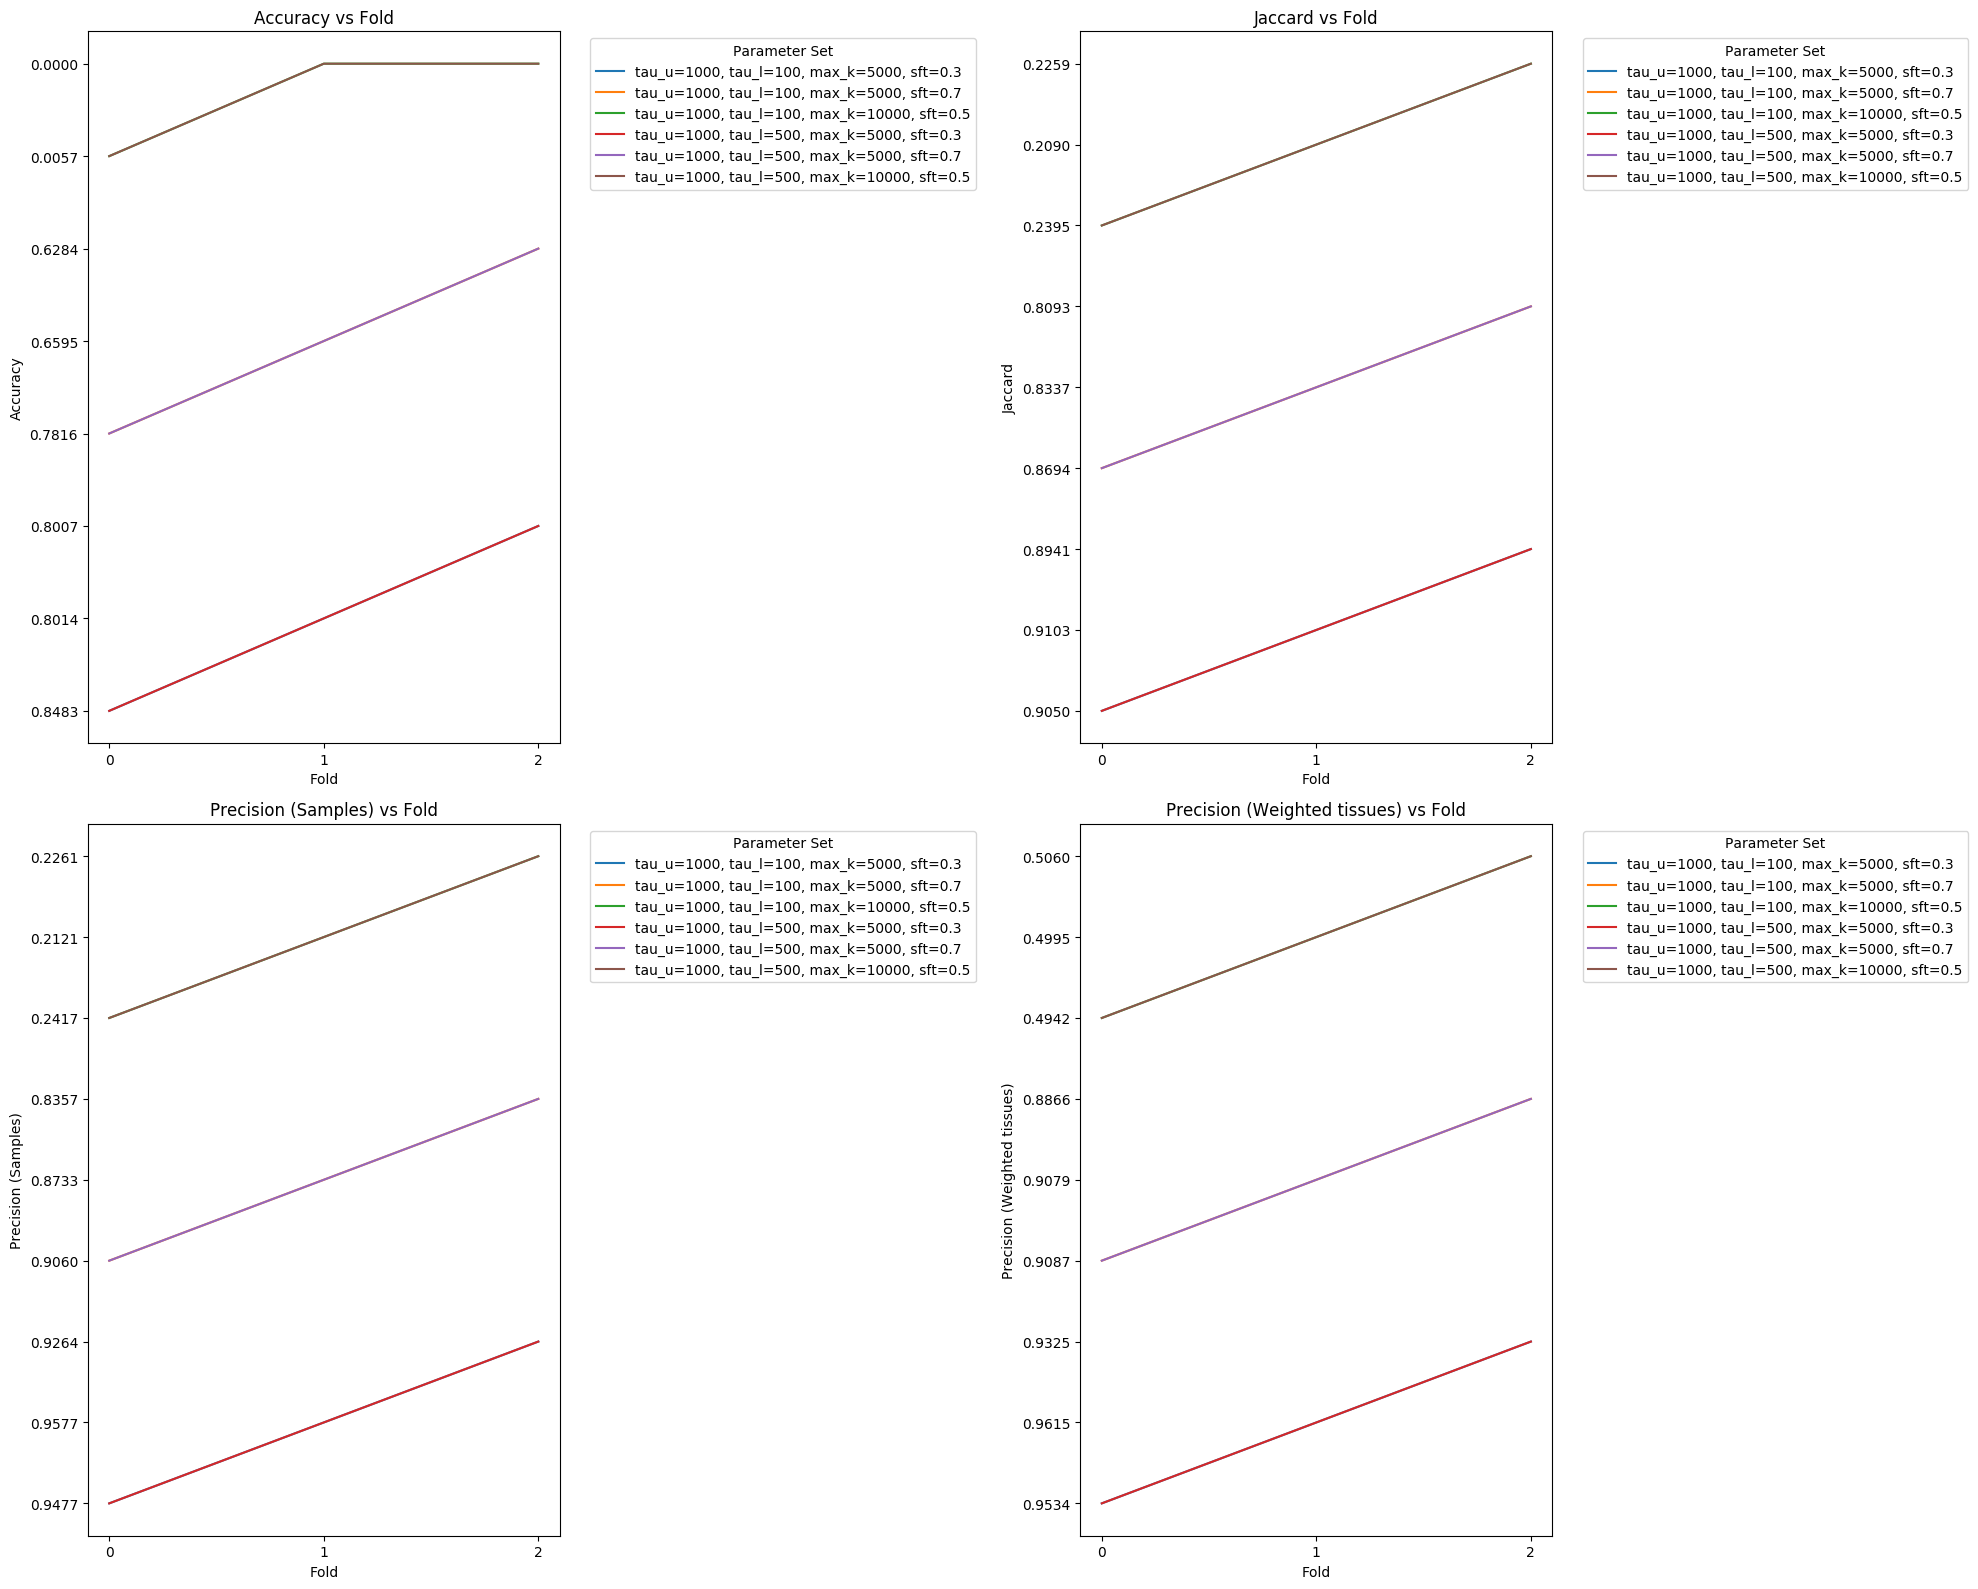

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from the file
with open('minipatch_gridsearch_convergence.txt', 'r') as f:
    lines = f.readlines()

# Parse the data
data = []
for i in range(0, len(lines), 5):
    if i + 4 < len(lines):
        params_line = lines[i].strip()
        if ': ' in params_line:
            params = [p.split(': ')[1] for p in params_line.split(', ')]
            metrics = [line.strip().split(': ')[1] for line in lines[i+1:i+5] if ': ' in line]
            if len(params) == 5 and len(metrics) == 4:
                data.append(params + metrics)

# Create a DataFrame
columns = ['fold', 'tau_u', 'tau_l', 'max_k', 'selection_frequency_threshold', 
           'Accuracy', 'Jaccard', 'Precision (Samples)', 'Precision (Weighted tissues)']
df = pd.DataFrame(data, columns=columns)


# After creating the DataFrame, add this:

# Create a unique identifier for each parameter set
df['param_set'] = df.apply(lambda row: f"tau_u={row['tau_u']}, tau_l={row['tau_l']}, max_k={row['max_k']}, sft={row['selection_frequency_threshold']}", axis=1)

# Create plots
metrics = ['Accuracy', 'Jaccard', 'Precision (Samples)', 'Precision (Weighted tissues)']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    for param_set in df['param_set'].unique():
        subset = df[df['param_set'] == param_set]
        ax.plot(subset['fold'], subset[metric], label=param_set)
    ax.set_title(f'{metric} vs Fold')
    ax.set_xlabel('Fold')
    ax.set_ylabel(metric)
    ax.legend(title='Parameter Set', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# plt.savefig('metric_visualization.png', bbox_inches='tight')
plt.show()



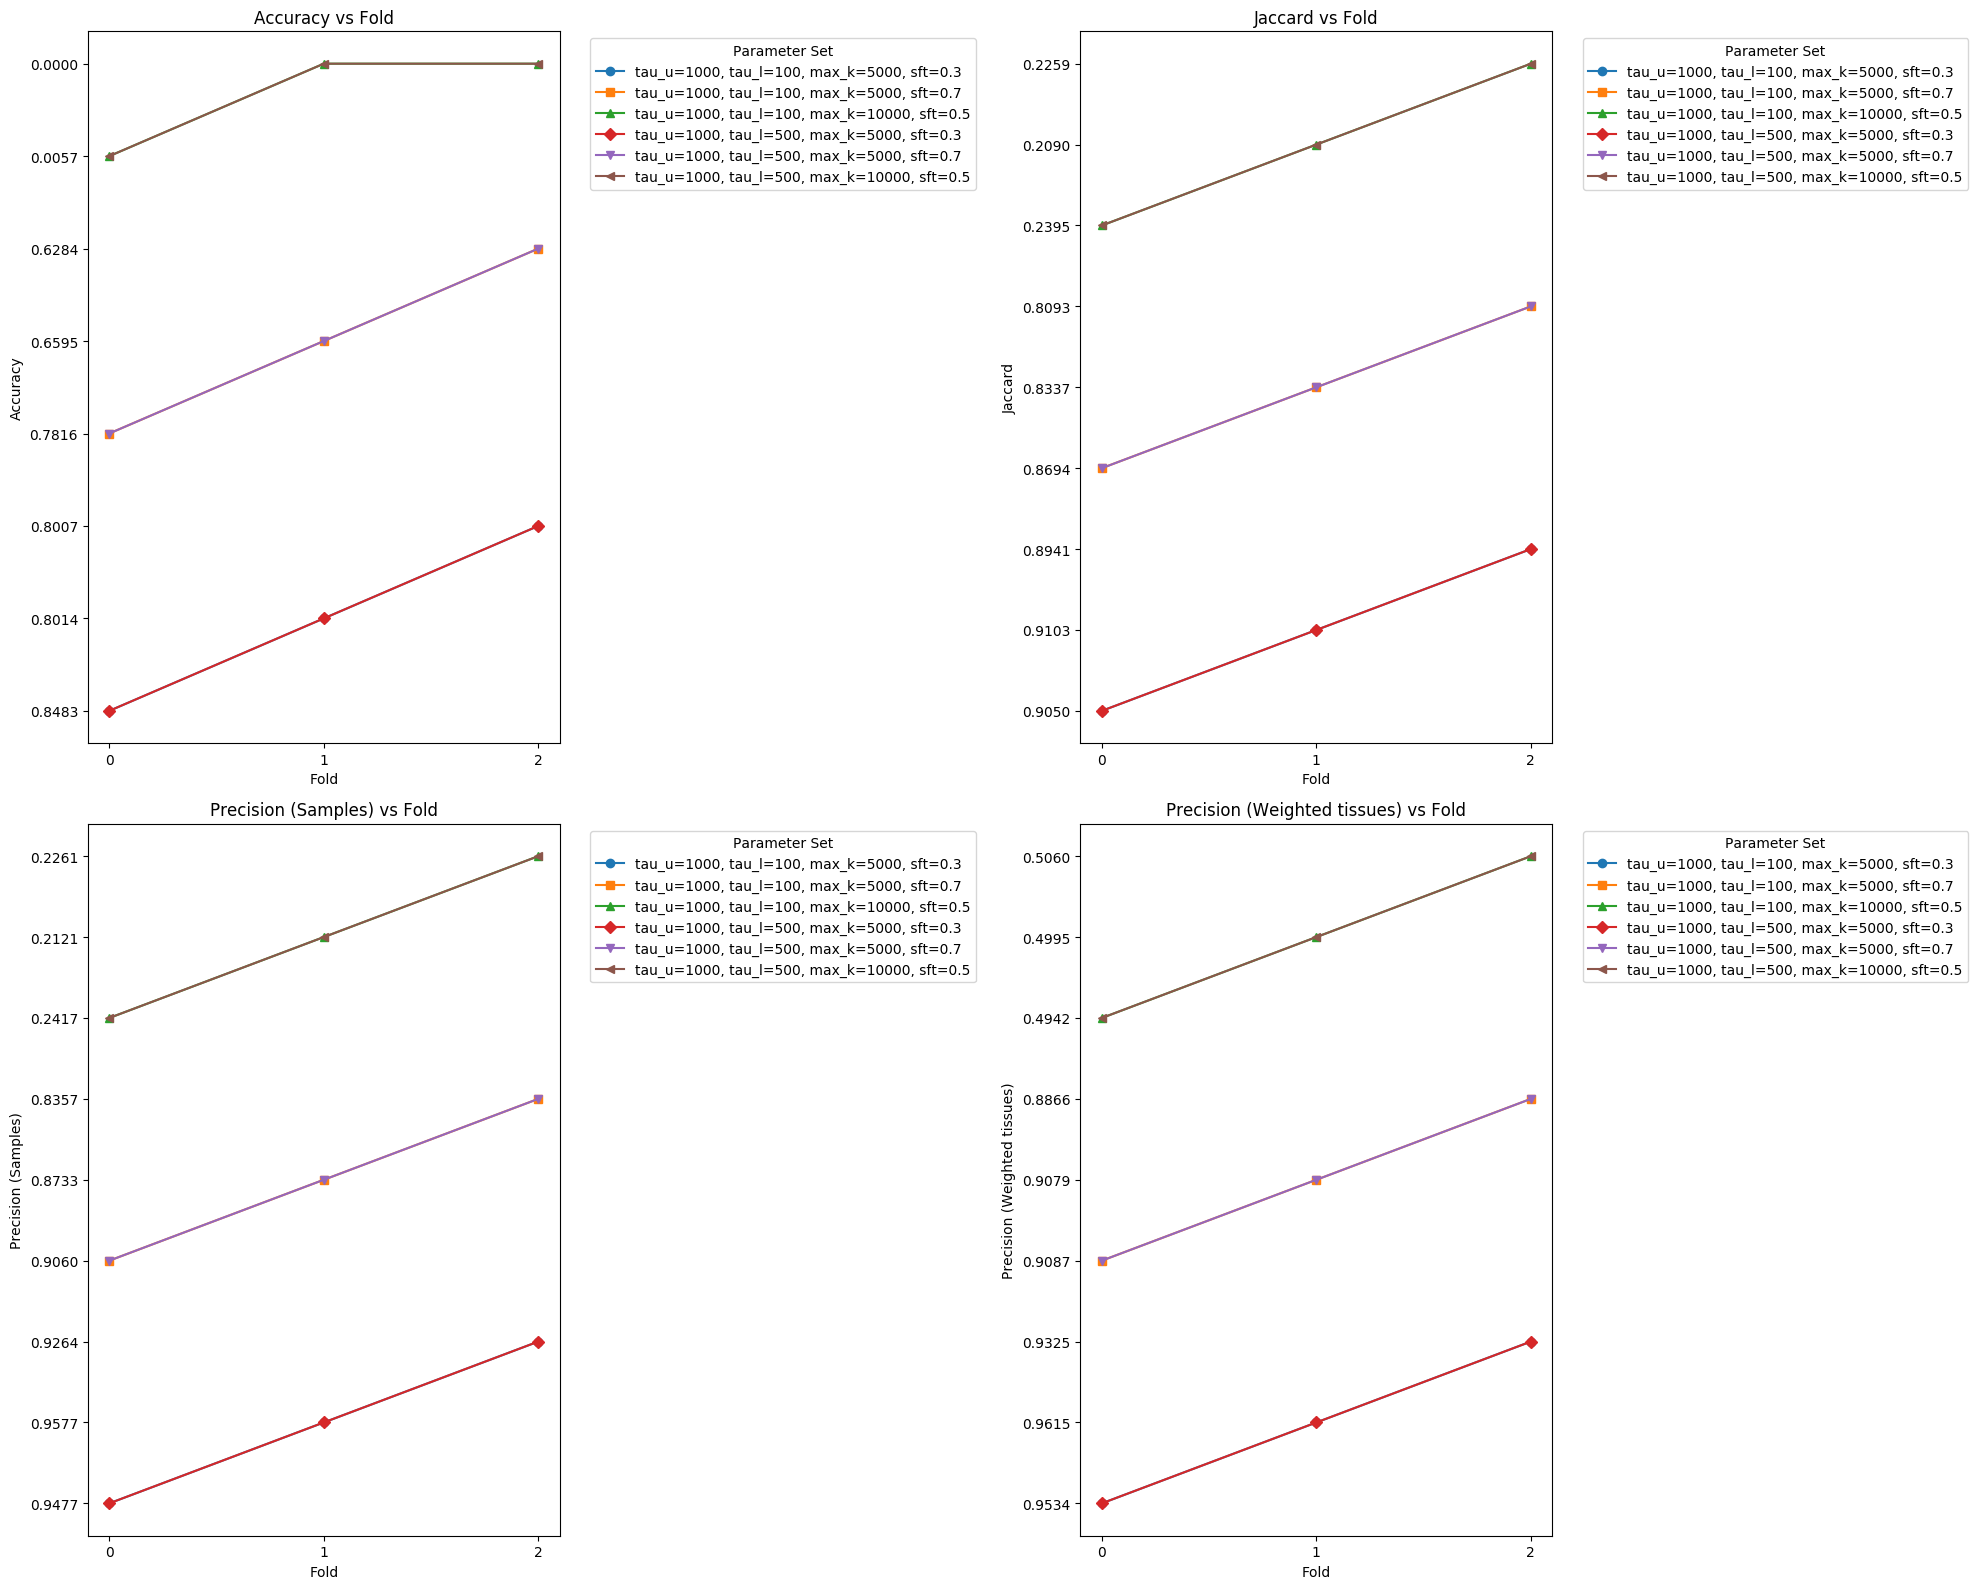

In [7]:
# Create plots
metrics = ['Accuracy', 'Jaccard', 'Precision (Samples)', 'Precision (Weighted tissues)']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, param_set in enumerate(df['param_set'].unique()):
        subset = df[df['param_set'] == param_set]
        ax.plot(subset['fold'], subset[metric], label=param_set, marker=markers[j % len(markers)])
    ax.set_title(f'{metric} vs Fold')
    ax.set_xlabel('Fold')
    ax.set_ylabel(metric)
    ax.legend(title='Parameter Set', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('metric_visualization.png', bbox_inches='tight')
plt.show()

In [8]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, jaccard_score, precision_score

from mplearn.feature_selection._adaptive_stable_minipatch_selection import AdaSTAMPS
from mplearn.feature_selection.base_selector import DecisionTreeSelector

import utils
import pickle

import random
import numpy as np
import networkx as nx
import utils
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

random.seed(9)
np.random.seed(9)

Mv, meta, mapping = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise', 'rb'))
le = LabelEncoder().fit(meta['tissue_name'].unique())
meta_le = le.transform(meta['tissue_name'].values)
subtree = nx.read_multiline_adjlist(path="uberon_sep2024_atleast2_adjlist", create_using=nx.MultiDiGraph)
mlb = MultiLabelBinarizer().fit([[utils.id_to_name[node] for node in subtree.nodes]])


params = {
        "mode": "ee", 
        "m_ratio": np.sqrt(Mv.shape[1]) / Mv.shape[1],
        "n_ratio": np.sqrt(Mv.shape[0]) / Mv.shape[0],
        "E": 10,
        "active_threshold": 0.1,
        "gamma_min": 0.5,
        "gamma_max": 1.0,
        "gamma_len": 50,
        "num_last_iterations": 100,
        "tau_u": 1000,
        "tau_l": 100,
        "max_k": 5000
    }

def load_fold_data():
    """Load fold data."""
    with open('./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise_fold_Mvs', 'rb') as f:
        return pickle.load(f)
    
fold_Mvs = load_fold_data()

print("training minipatch per fold...")
minipatch_per_fold = dict()
for fold, (rest_Mv_all, rest_meta, holdout_Mv_all, holdout_meta) in fold_Mvs.items():
    print(f"fold: {fold}")
    dt = DecisionTreeSelector(random_state=9)
    selector = AdaSTAMPS(base_selector=dt,
                         minipatch_m_ratio=params['m_ratio'],
                         minipatch_n_ratio=params['n_ratio'],
                         random_state=9,
                         verbose=1,
                         sampling_options={'mode': 'ee',
                                           'E': params['E'], 
                                           'active_set_thr': params['active_threshold'], 
                                           'gamma_min': params['gamma_min'], 
                                           'gamma_max': params['gamma_max'], 
                                           'gamma_len': params['gamma_len']},
                         stopping_criteria_options={'tau_u': params['tau_u'],
                                                    'tau_l': params['tau_l'],
                                                    'num_last_iterations': params['num_last_iterations'],
                                                    'max_k': None,
                                                    # 'max_k': params['max_k']
                                                    })  
    print(rest_Mv_all.shape, holdout_Mv_all.shape)

    holdout_meta_le = le.transform(holdout_meta['tissue_name'].values)
    rest_meta_le = le.transform(rest_meta['tissue_name'].values)

    fitted_selector = selector.fit(rest_Mv_all.values, rest_meta_le)
    print(f"iterations: {fitted_selector.last_k_}")
    
    minipatch_per_fold[fold] = fitted_selector

with open("minipatch_per_fold_34450", "wb") as f:
    dill.dump(minipatch_per_fold, f)

training minipatch per fold...
fold: 0
(1734, 473821) (870, 473821)
==== Maximum number of iteration reached. ======
iterations: 34450
fold: 1
(1723, 473821) (881, 473821)
==== Maximum number of iteration reached. ======
iterations: 34450
fold: 2
(1751, 473821) (853, 473821)
==== Maximum number of iteration reached. ======
iterations: 34450


In [9]:
# see if stable across folds

In [10]:
# see distribution of selection frequencies

In [ ]:
with open("minipatch_per_fold_34450", "wb") as f:
    dill.dump(minipatch_per_fold, f)

In [13]:
minipatch_per_fold

{0: <mplearn.feature_selection._adaptive_stable_minipatch_selection.AdaSTAMPS at 0x7fc6c41707f0>,
 1: <mplearn.feature_selection._adaptive_stable_minipatch_selection.AdaSTAMPS at 0x7fc6c4170e80>,
 2: <mplearn.feature_selection._adaptive_stable_minipatch_selection.AdaSTAMPS at 0x7fcaa54df370>}

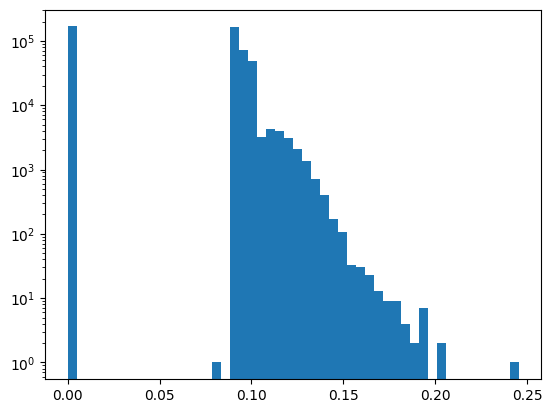

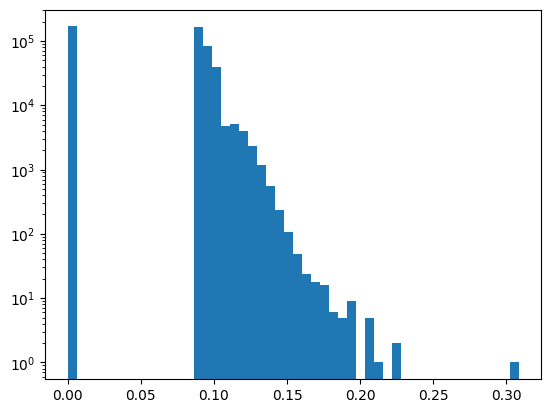

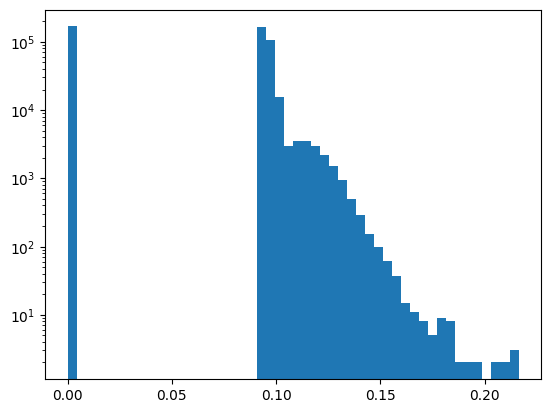

In [15]:
for fold, minipatch in minipatch_per_fold.items():
    plt.figure(f"fold{fold}")
    plt.hist(minipatch.Pi_hat_last_k_, bins=50)
    plt.yscale('log')

In [22]:
for fold in range(3):
    print(fold)
    fold_minipatch = minipatch_per_fold[fold]
    for selection_freq_threshold in [round(x,2) for x in np.arange(0, 0.3, 0.05)]:
        print(f">{selection_freq_threshold}: {len(fold_minipatch.Pi_hat_last_k_[fold_minipatch.Pi_hat_last_k_>selection_freq_threshold])}")
    print()

0
>0.0: 306292
>0.05: 306292
>0.1: 20286
>0.15: 161
>0.2: 3
>0.25: 0

1
>0.0: 306068
>0.05: 306068
>0.1: 20176
>0.15: 189
>0.2: 9
>0.25: 1

2
>0.0: 306069
>0.05: 306069
>0.1: 20124
>0.15: 193
>0.2: 7
>0.25: 0



In [23]:
# lower bound might be smaller than 100 - decrease convergence criteria

In [25]:
# lower bound maybe number of labels that we have

In [2]:
import dill

In [4]:
filename = './../data/minipatch_per_fold_default'
with open(filename, 'rb') as f:
    default = dill.load(f)

In [5]:
filename = './../data/minipatch_per_fold_default_max100000'
with open(filename, 'rb') as f:
    max100000 = dill.load(f)

In [6]:
Mv, meta, mapping = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise', 'rb'))

In [10]:
for fold in range(3):
    fold_default = Mv.columns[default[fold].Pi_hat_last_k_ > 0.60]
    fold_max100000 = Mv.columns[max100000[fold] > 0.15]
    
    shared = set(fold_default).intersection(set(fold_max100000))
    
    print(len(fold_default), len(fold_max100000), len(shared))

120 479 7
125 84 4
123 23 1


In [11]:
default_folds = dict()
max_folds = dict()

for fold in range(3):
    default_folds[fold] = Mv.columns[default[fold].Pi_hat_last_k_ > 0.60]
    max_folds[fold] = Mv.columns[max100000[fold] > 0.15]

In [12]:
set(default_folds[0]).intersection(set(default_folds[1])).intersection(set(default_folds[2]))

set()

In [13]:
set(max_folds[0]).intersection(set(max_folds[1])).intersection(set(max_folds[2]))

{'cg02460419',
 'cg02971262',
 'cg04147906',
 'cg07856521',
 'cg13924510',
 'cg16037981',
 'cg18051527',
 'cg20112500'}

In [14]:
for fold in range(3):
    print(len(set(default_folds[fold]).intersection({'cg02460419',
 'cg02971262',
 'cg04147906',
 'cg07856521',
 'cg13924510',
 'cg16037981',
 'cg18051527',
 'cg20112500'})))

0
0
1
